In [8]:
import pandas as pd

# Load core files
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

# Merge store metadata
train = pd.merge(train, stores, on='Store')

# Merge economic features and holiday flags
train = pd.merge(train, features, on=['Store', 'Date'])

# Convert date column to datetime format for time series operations
train['Date'] = pd.to_datetime(train['Date'])

Comment: Merging ensures each sales record is enriched with store type, size, and macroeconomic context — essential for regional and seasonal breakdowns.


In [9]:
train['Month'] = train['Date'].dt.to_period('M')
monthly_sales = train.groupby('Month')['Weekly_Sales'].sum().reset_index()

Comment: Weekly data is aggregated to monthly granularity to align with the task’s focus on trend and seasonality.


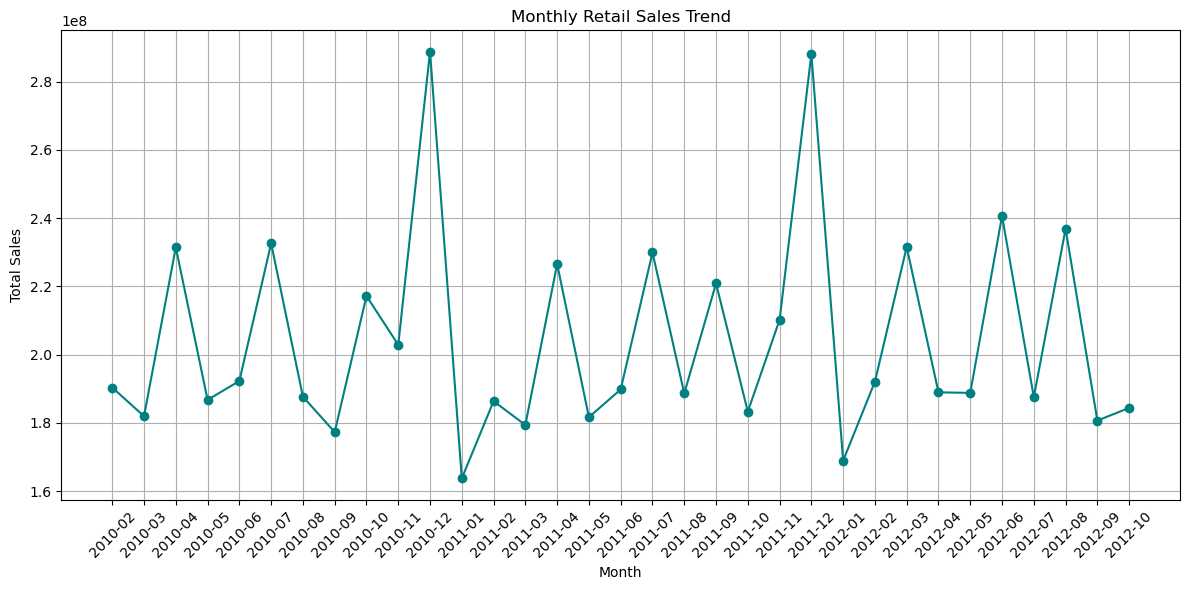

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Weekly_Sales'], marker='o', color='teal')
plt.title('Monthly Retail Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: This visual reveals macro-level sales fluctuations, helping identify growth periods, dips, and potential seasonal cycles.


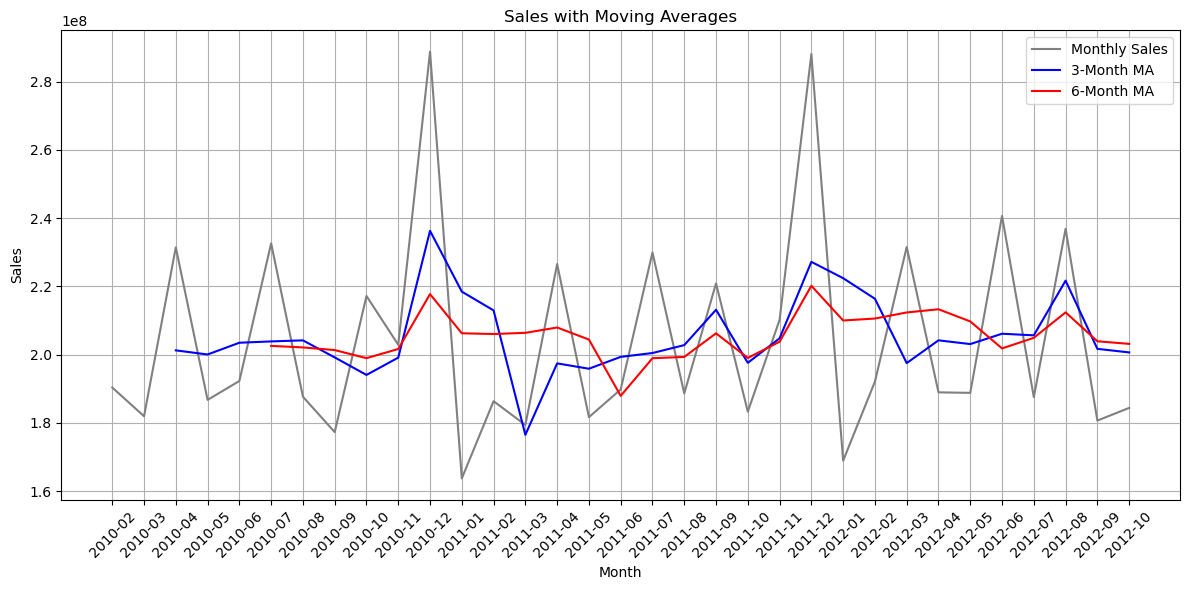

In [11]:
monthly_sales['MA_3'] = monthly_sales['Weekly_Sales'].rolling(window=3).mean()
monthly_sales['MA_6'] = monthly_sales['Weekly_Sales'].rolling(window=6).mean()

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['Weekly_Sales'], label='Monthly Sales', color='gray')
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['MA_3'], label='3-Month MA', color='blue')
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['MA_6'], label='6-Month MA', color='red')
plt.title('Sales with Moving Averages')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: Rolling averages smooth short-term volatility, revealing underlying trends and aiding in forecasting.


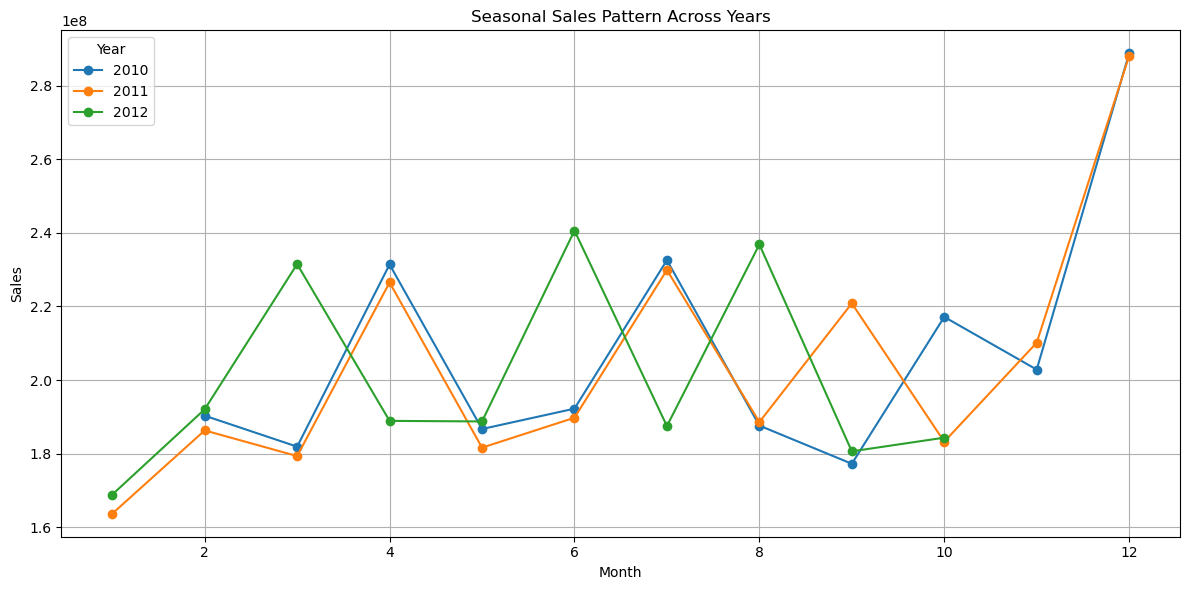

In [12]:
train['Year'] = train['Date'].dt.year
train['Month_Num'] = train['Date'].dt.month

seasonal = train.groupby(['Year', 'Month_Num'])['Weekly_Sales'].sum().unstack(0)
seasonal.plot(figsize=(12,6), marker='o')
plt.title('Seasonal Sales Pattern Across Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: This reveals recurring monthly patterns — e.g., holiday spikes or summer dips — across multiple years.


In [13]:
# Product-level breakdown (Department as proxy)
product_sales = train.groupby(['Department', 'Month'])['Weekly_Sales'].sum().unstack(0)

# Region-level breakdown (Store Type as proxy)
region_sales = train.groupby(['Type', 'Month'])['Weekly_Sales'].sum().unstack(0)

KeyError: 'Department'

In [14]:
# Product-level breakdown (Dept as proxy for product category)
product_sales = train.groupby(['Dept', 'Month'])['Weekly_Sales'].sum().unstack(0)

# Region-level breakdown (Store Type as proxy)
region_sales = train.groupby(['Type', 'Month'])['Weekly_Sales'].sum().unstack(0)

We use Dept as a proxy for product category, aligning with Walmart’s internal department codes. This allows us to analyze sales performance across product lines over time.


Comment: These breakdowns support strategic insights — which departments or regions drive revenue growth over time.


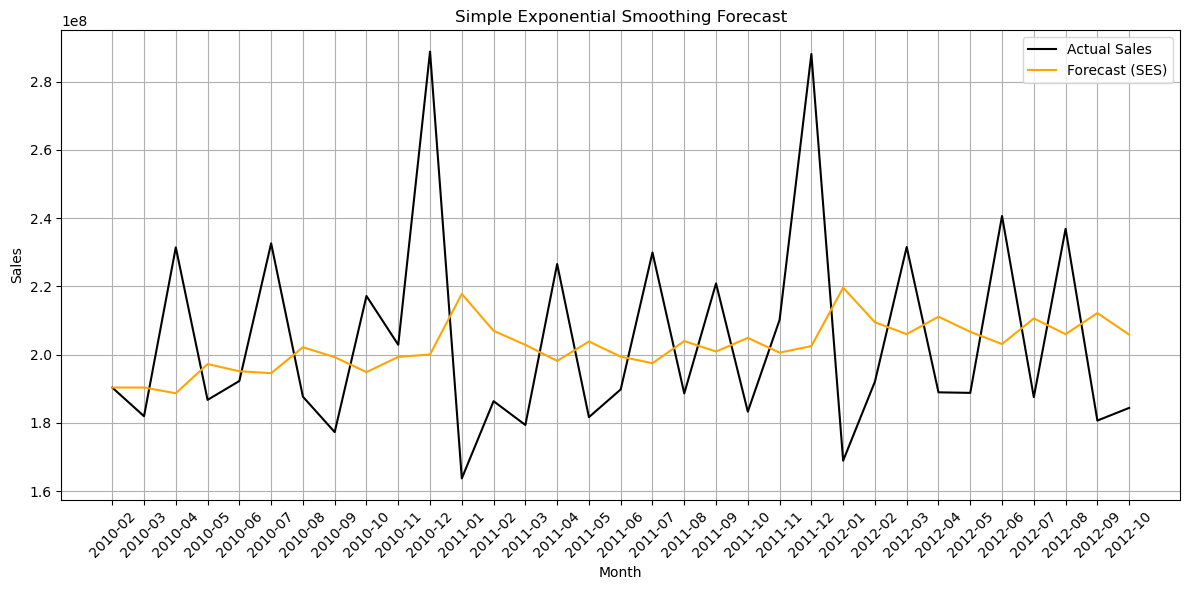

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ts = monthly_sales['Weekly_Sales'].values
model = SimpleExpSmoothing(ts)
fit = model.fit(smoothing_level=0.2, optimized=False)
forecast = fit.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Month'].astype(str), ts, label='Actual Sales', color='black')
plt.plot(monthly_sales['Month'].astype(str), forecast, label='Forecast (SES)', color='orange')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()